In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm

In [29]:
# set global random state
random_state = 0
np.random.seed(random_state)

# set pandas options
pd.set_option('display.max_columns', None)

In [30]:
# import raw data
raw_data = fetch_california_housing()
df = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
df['Price'] = raw_data.target

In [31]:
# get preliminary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [32]:
print(df.describe(include='all'))
print(df.head())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         Price  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [33]:
# The data has no null values. However, below is example code for imputing null values
# handle null values
# df.dropna(axis=0, inplace=True)
# mean = df['x'].mean
# df['x'].replace(np.nan, mean, inplace=True)

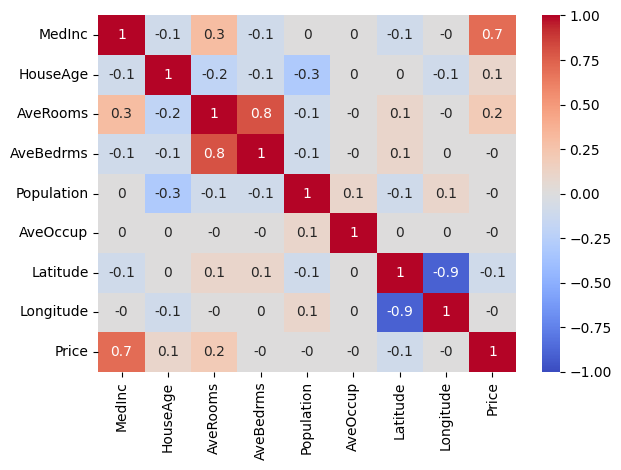

In [34]:
# EDA
# correlation matrix
corr = df.corr()
corr_round = np.around(corr, decimals=1)
sns.heatmap(corr_round, vmin=-1, cmap="coolwarm", annot=True)
plt.tight_layout()
plt.show()

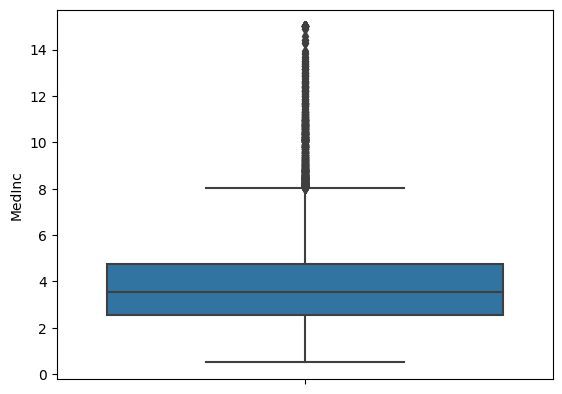

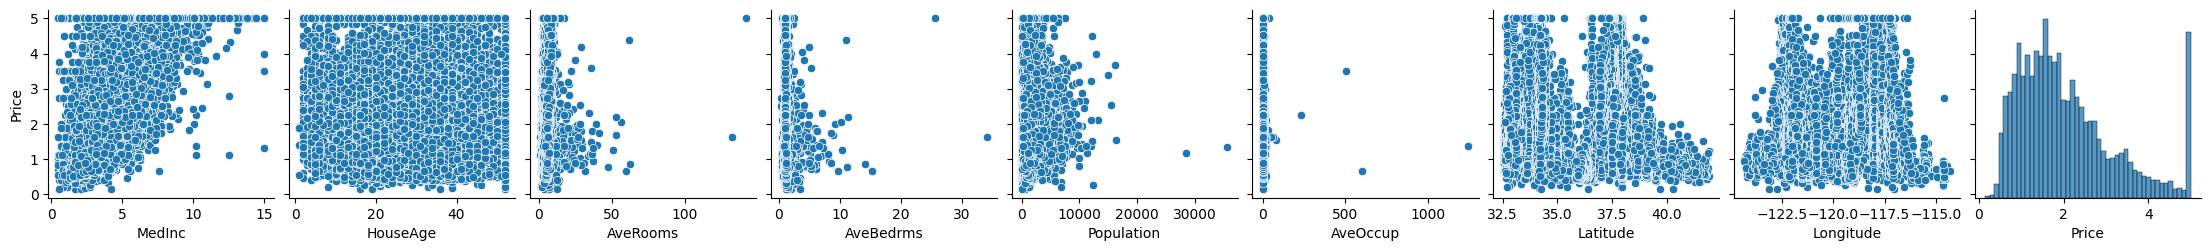

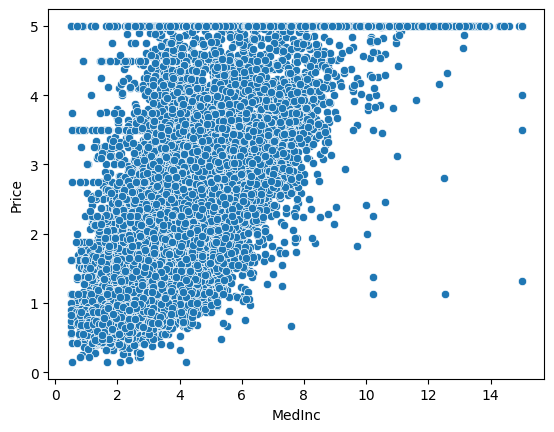

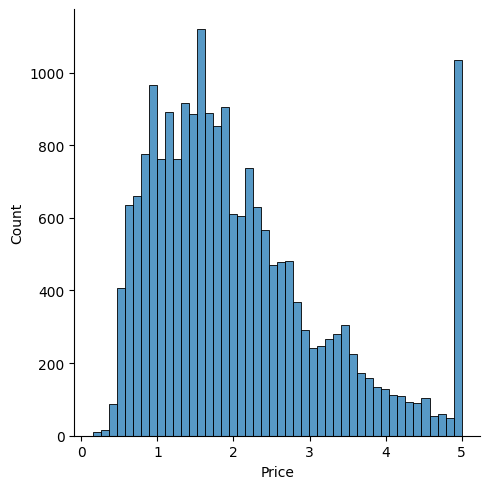

In [35]:
# plots to identify relations
sns.boxplot(data=df, y='MedInc')
plt.show()

sns.pairplot(df, y_vars=['Price'])
plt.show()

sns.scatterplot(df, x='MedInc', y='Price')
plt.show()

sns.displot(df, x='Price')
plt.show()

In [36]:
"""
Clearly Median income is the only correlated factor to Price. 
However, backward elimination used at later stage for further feature selection. 
Lat and Long data can be mapped to Census Blocks and create Location 
categorical variable, which might be better factor to include.         
"""

'\nClearly Median income is the only correlated factor to Price. \nHowever, backward elimination used at later stage for further feature selection. \nLat and Long data can be mapped to Census Blocks and create Location \ncategorical variable, which might be better factor to include.         \n'

In [37]:
# remove outliers
# function to get outlier count for each column
def outlier_count(input_df: DataFrame) -> dict:
    input_df = input_df.select_dtypes(exclude='object')

    q1 = input_df.quantile(0.25)
    q3 = input_df.quantile(0.75)
    iqr = q3 - q1

    return ((input_df < (q1 - 1.5 * iqr)) | (input_df > (q3 + 1.5 * iqr))).sum()


print(outlier_count(df))

MedInc         681
HouseAge         0
AveRooms       511
AveBedrms     1424
Population    1196
AveOccup       711
Latitude         0
Longitude        0
Price         1071
dtype: int64


In [38]:
# function to get quantile bounds for a column
def outlier_range(col):
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    return lower_range, upper_range


# get upper and lower bounds for price column
lower_bound, upper_bound = outlier_range(df['Price'])

# filter out Price outliers from df
df = df[(df['Price'] <= upper_bound) & (df['Price'] >= lower_bound)]

In [39]:
# Pre-Processing Pipeline
# one-hot encoding & Standard Scaling

categorical_features = df.select_dtypes(include='object').columns.to_list()
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

numeric_features = df.select_dtypes(exclude='object').columns.to_list()
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

processed_columns = numeric_features

df_processed = pd.DataFrame(preprocessor.fit_transform(df), index=df.index, columns=processed_columns)

In [40]:
# Feature selection through linear model backward elimination
X = df_processed.drop(columns=['Price'])
Y = df_processed['Price']

cols = list(X.columns)
while len(cols) > 0:
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    ols_model = sm.OLS(Y, X_1).fit()
    print(ols_model.summary())
    p = pd.Series(ols_model.pvalues.values[1:], index=cols)
    p_max = max(p)
    feature_with_p_max = p.idxmax()
    if p_max > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break
selected_features = cols
print(selected_features)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3288.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:09:11   Log-Likelihood:                -19428.
No. Observations:               19569   AIC:                         3.887e+04
Df Residuals:                   19560   BIC:                         3.895e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.393e-16      0.005  -5.12e-14      1.0

In [41]:
# select relevant features only

df_ml = df_processed[selected_features + ['Price']]

In [42]:
# train test split
X = df_ml.drop(columns=['Price'])
Y = df_ml['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

In [43]:
# define performance measure dataframe and function to evaluate models
performance = pd.DataFrame({'Model': [],
                            'Train R2': [],
                            'Train RMSE': [],
                            'Test R2': [],
                            'Test RMSE': []})

In [44]:
def performance_measure(model_name, y_train, y_test, y_train_predict, y_test_predict):
    r_sq_train = r2_score(y_train, y_train_predict)
    rmse_train = mean_squared_error(y_train, y_train_predict, squared=False)
    r_sq_test = r2_score(y_test, y_test_predict)
    rmse_test = mean_squared_error(y_test, y_test_predict, squared=False)
    performance_df = pd.concat([performance, pd.DataFrame({'Model': [model_name],
                                                           'Train R2': [r_sq_train],
                                                           'Train RMSE': [rmse_train],
                                                           'Test R2': [r_sq_test],
                                                           'Test RMSE': [rmse_test]})], ignore_index=True)
    return performance_df


In [45]:
# Model 1 :- Linear Regression
linear = LinearRegression()
linear.fit(X_train, Y_train)
print('R2: ', linear.score(X_train, Y_train))
print('Coefficients: ', linear.coef_)
print('Intercept: ', linear.intercept_)

linear_train_predictions = linear.predict(X_train)
linear_test_predictions = linear.predict(X_test)

R2:  0.5751266530191448
Coefficients:  [ 0.70900661  0.10029001 -0.29260142  0.3512849  -0.03792835 -0.85620873
 -0.83307646]
Intercept:  0.0026132897969566005


In [46]:
#  Measure performance of Linear Model
performance = performance_measure(model_name='Linear',
                                  y_train=Y_train,
                                  y_test=Y_test,
                                  y_train_predict=linear_train_predictions,
                                  y_test_predict=linear_test_predictions)
print(performance)

    Model  Train R2  Train RMSE   Test R2  Test RMSE
0  Linear  0.575127    0.650678  0.558822   0.668814


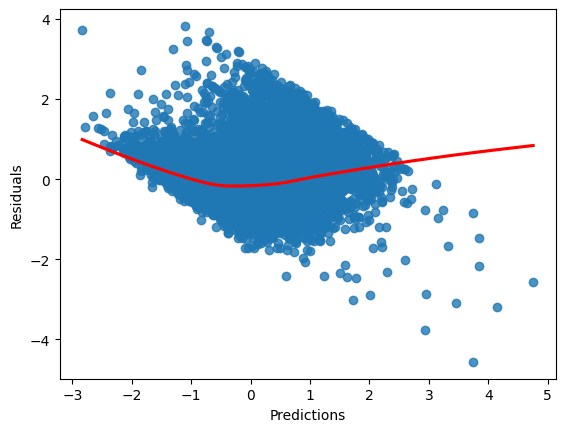

In [47]:
# residual plot to check any patterns
residuals = Y_train - linear_train_predictions
resid_plot = sns.regplot(x=linear_train_predictions, y=residuals, lowess=True, line_kws={'color': 'red'})
resid_plot.set(xlabel='Predictions', ylabel='Residuals')
plt.show()

In [48]:
"""
The residual plot shows pattern indicating non-linear relationship  
"""

'\nThe residual plot shows pattern indicating non-linear relationship  \n'

In [49]:
# Model 2 :- Random Forest Regression

rf = RandomForestRegressor(n_estimators=200,
                           oob_score=True,
                           random_state=random_state,
                           verbose=1,
                           n_jobs=-1)
rf.fit(X_train, Y_train)
rf_train_predict = rf.predict(X_train)
rf_test_predict = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [50]:
#  Measure performance of random forest
performance = performance_measure(model_name='Random Forest',
                                  y_train=Y_train,
                                  y_test=Y_test,
                                  y_train_predict=rf_train_predict,
                                  y_test_predict=rf_test_predict)

print(performance)

           Model  Train R2  Train RMSE   Test R2  Test RMSE
0         Linear  0.575127    0.650678  0.558822   0.668814
1  Random Forest  0.969649    0.173910  0.790871   0.460475


In [51]:
# Model 3 :- XGBoost
xgb = XGBRegressor(n_estimators=200,
                   objective='reg:squarederror',
                   random_state=random_state)
xgb.fit(X_train, Y_train)
xgb_train_predict = xgb.predict(X_train)
xgb_test_predict = xgb.predict(X_test)

In [52]:
#  Measure performance of XGBoost
performance = performance_measure(model_name='XGBoost',
                                  y_train=Y_train,
                                  y_test=Y_test,
                                  y_train_predict=xgb_train_predict,
                                  y_test_predict=xgb_test_predict)
print(performance)

           Model  Train R2  Train RMSE   Test R2  Test RMSE
0         Linear  0.575127    0.650678  0.558822   0.668814
1  Random Forest  0.969649    0.173910  0.790871   0.460475
2        XGBoost  0.958278    0.203902  0.814893   0.433221


In [53]:
"""
XGBoost performs the best of all models with test R2 of 81.5% and RMSE of 0.43
Grid Search CV can be implemented to further tune hyper-parameters
"""

'\nGrid Search CV can be implemented to further tune hyper-parameters\n'